In [ ]:
# Cell 1: Setup and Installations

# 1.1 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# 1.2 Install required libraries
# Note: TRL is included for consistency with your original script, but is not
# strictly required for this sequence classification task.
!pip install -Uq transformers
!pip install -Uq peft
!pip install -Uq trl
!pip install -Uq accelerate
!pip install -Uq datasets
!pip install -Uq bitsandbytes

# Install Flash Attention 2
!pip install flash-attn==2.7.4.post1 \
  --extra-index-url https://download.pytorch.org/whl/cu124 \
  --no-build-isolation


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Replace 'path/to/your/key.txt' with the actual path to your key file in Google Drive
key_file_path = '/content/drive/MyDrive/Erdos/huggingface_key.txt'

try:
    with open(key_file_path, 'r') as f:
        key = f.read().strip()
    print("Key loaded successfully.")
except FileNotFoundError:
    print(f"Error: Key file not found at {key_file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Key loaded successfully.


In [ ]:
from huggingface_hub import login

login(key)

In [ ]:
# Cell 2: Project Configuration

class Config:
    # Model ID from Hugging Face Hub
    MODEL_ID = "Qwen/Qwen3-4B"

    # Local path to the unzipped dataset
    DATASET_PATH = "/content/drive/MyDrive/Erdos/finetuning_data/level-1-binary/level-1-binary"

    # Directory for saving the final model adapter
    OUTPUT_DIR = "/content/drive/MyDrive/Erdos/finetuning_data/qwen3B_finetuning"

    # Number of labels for the classification task
    NUM_LABELS = 2

In [ ]:
# Cell 3: Data Loading and Preprocessing

from datasets import load_from_disk
from transformers import AutoTokenizer

# 3.1 Load the tokenizer needed for preprocessing
# This will be the same tokenizer used for the model later.
tokenizer = AutoTokenizer.from_pretrained(
    Config.MODEL_ID,
    trust_remote_code=True
)

tokenizer.padding_side = "left"      # Flash-Attn requires left padding
# Set a padding token if one is not already defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 3.2 Load the raw dataset from disk
raw_dataset = load_from_disk(Config.DATASET_PATH)

# 3.3 Define the preprocessing function
def preprocess_function(examples):
    """
    Formats the input text and tokenizes it for sequence classification.
    The label is passed through untouched.
    """
    # Create a single input string per example
    # Note: We do not include the label (0 or 1) in the input text itself.
    system_prompt = "Analyze the following mathematical problem and solution to determine if the solution is correct or flawed."
    input_texts = [
        f"{system_prompt}\n\n### Problem:\n{q}\n\n### Solution:\n{s}"
        for q, s in zip(examples["question"], examples["solution"])
    ]

    # Tokenize the texts
    # The tokenizer will return 'input_ids' and 'attention_mask'.
    return tokenizer(
        input_texts,
        truncation=True,
        max_length=512,  # A reasonable max length for these problems
        padding=False    # Padding will be handled by the data collator
    )

# 3.4 Apply the preprocessing function to the dataset
# We use batched=True for efficiency and remove original text columns.
tokenized_dataset = raw_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["question", "solution"]
)

# 3.5 Verify the new dataset structure
print("--- Tokenized dataset ---")
print(tokenized_dataset)
print("\nExample record:")
print(tokenized_dataset["train"][0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/412 [00:00<?, ? examples/s]

--- Tokenized dataset ---
DatasetDict({
    train: Dataset({
        features: ['index', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3296
    })
    validation: Dataset({
        features: ['index', 'label', 'input_ids', 'attention_mask'],
        num_rows: 412
    })
    test: Dataset({
        features: ['index', 'label', 'input_ids', 'attention_mask'],
        num_rows: 412
    })
})

Example record:
{'index': 1325, 'label': 1, 'input_ids': [2082, 55856, 279, 2701, 35972, 3491, 323, 6291, 311, 8253, 421, 279, 6291, 374, 4396, 476, 46908, 382, 14374, 22079, 510, 50, 745, 15303, 400, 16, 15, 15, 15, 518, 975, 1537, 2254, 13, 1096, 2254, 11, 1340, 3949, 264, 220, 16, 15, 4, 4828, 13, 2585, 1753, 3220, 686, 1340, 1281, 304, 2790, 369, 279, 1378, 3951, 1939, 14374, 12478, 510, 1986, 2254, 1340, 686, 7232, 400, 16, 15, 15, 15, 353, 320, 16, 15, 14, 16, 15, 15, 8, 284, 400, 2442, 16, 15, 15, 15, 6599, 16, 15, 14, 16, 15, 15, 11730, 16, 15, 15, 2452, 16, 15, 15, 624, 641, 279

In [ ]:
# Cell 3.5: Merge Datasets for Training

from datasets import concatenate_datasets, DatasetDict

# 3.5.1 Combine the 'train' and 'validation' splits
# This creates a larger training set for the model.
full_train_dataset = concatenate_datasets(
    [tokenized_dataset["train"], tokenized_dataset["validation"]]
)

# 3.5.2 Create a new DatasetDict with the merged training set and the original test set
final_dataset = DatasetDict({
    "train": full_train_dataset,
    "test": tokenized_dataset["test"]
})

print("--- Merged dataset for training ---")

--- Merged dataset for training ---


In [ ]:
# ────────────────────────────────────────────────────────────────
# Cell 4-5 · Tokenizer, 4-bit backbone → LoRA + custom classifier
# ────────────────────────────────────────────────────────────────
import torch, torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType

# ----- Config -----
NUM_LABELS = Config.NUM_LABELS      # e.g. 2
DTYPE       = torch.bfloat16        # A100 native

quant_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=DTYPE,
)

tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_ID, trust_remote_code=True)
tokenizer.padding_side = "left"      # Flash-Attn requires left padding
tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token

# 1. load causal-LM in 4-bit
backbone = AutoModelForCausalLM.from_pretrained(
    Config.MODEL_ID,
    quantization_config=quant_cfg,
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="flash_attention_2",
)
backbone.config.pad_token_id = tokenizer.pad_token_id

# 2. LoRA on all linear layers
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,   # still “SEQ_CLS” so PEFT knows to train a head
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules="all-linear",
)
backbone = get_peft_model(backbone, lora_cfg)

# 3. custom classification wrapper
class GPTSequenceClassifier(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.base = base_model                       # LoRA-augmented Φ-4-mini
        hidden = base_model.config.hidden_size
        self.classifier = nn.Linear(hidden, num_labels, bias=True)
        self.num_labels = num_labels

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kw):
        outputs = self.base(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            **kw,
        )
        last_hidden = outputs.hidden_states[-1]      # (B, L, H)
        pooled      = last_hidden[:, -1, :]          # use last token
        logits      = self.classifier(pooled)        # (B, num_labels)

        loss = None
        if labels is not None:
            loss = nn.functional.cross_entropy(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

model = GPTSequenceClassifier(backbone, NUM_LABELS)
# call on the LoRA-augmented backbone instead
backbone.print_trainable_parameters()
print("--- LoRA+classifier model ready ---")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 33,030,144 || all params: 4,055,498,240 || trainable%: 0.8145
--- LoRA+classifier model ready ---


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    """
    Compute metrics for binary classification
    """
    predictions, labels = eval_pred

    # Get the predicted class (argmax for multi-class, but for binary we can use > 0.5)
    if predictions.ndim == 2:
        # If logits are returned, take argmax
        predictions = np.argmax(predictions, axis=1)
    else:
        # If probabilities are returned, threshold at 0.5
        predictions = (predictions > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

training_args = TrainingArguments(
    output_dir=Config.OUTPUT_DIR,

    # —— Batching ——
    num_train_epochs=3,
    per_device_train_batch_size=2,   # safe default on 4-bit + A100
    gradient_accumulation_steps=16,   # effective 32

    # —— Optimiser / sched ——
    optim="paged_adamw_8bit",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,

    # —— Precision / memory ——
    bf16=True,                       # A100 native bf16
    gradient_checkpointing=False,

    # —— Logging / ckpt ——
    logging_strategy="steps",
    logging_steps=25,
    save_strategy="epoch",
    save_total_limit=1,
    report_to="none",
    save_safetensors=False,

    # —— Evaluation ——
    # evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    # eval_dataset=final_dataset["test"],   # drop if you have no split
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,            # ↳ defined earlier
)

print("--- Trainer initialised ---")

--- Trainer initialised ---


/tmp/ipython-input-9-272316796.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Cell 8: Execute Training

print("Starting model training...")
trainer.train()
print("Training complete.")

Starting model training...


The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss
25,13.585500
50,11.523900
75,7.432800
100,4.504100
125,3.249100
150,3.870200
175,3.025600
200,2.823500
225,3.044200
250,1.414900


Training complete.


In [ ]:
# Cell 9: Final Evaluation and Saving

def compute_metrics_new(p):
    # HF passes either a plain ndarray or a tuple; handle both robustly
    logits = p.predictions[0] if isinstance(p.predictions, (tuple, list)) else p.predictions

    preds  = np.argmax(logits, axis=1)
    labels = p.label_ids
    return {"accuracy": (preds == labels).mean().item()}

trainer.compute_metrics = compute_metrics_new

# 9.1 Evaluate the model on the test set
print("\n--- Evaluating on the test set ---")
test_results = trainer.evaluate(eval_dataset=final_dataset["test"])

# 9.2 Print the evaluation results
print("Test set performance:")
print(test_results)

# 9.3 Save the final trained LoRA adapter
print(f"\nSaving final model adapter to {Config.OUTPUT_DIR}...")
trainer.save_model(Config.OUTPUT_DIR)
print("Model saved successfully.")


--- Evaluating on the test set ---


Test set performance:
{'eval_loss': 0.2257055789232254, 'eval_accuracy': 0.9393203883495146, 'eval_runtime': 16.7852, 'eval_samples_per_second': 24.545, 'eval_steps_per_second': 3.098, 'epoch': 3.0}

Saving final model adapter to /content/drive/MyDrive/Erdos/finetuning_data/llama3B_finetuning...
Model saved successfully.


In [ ]:
print(final_dataset['test'][0])

{'index': 1417, 'label': 0, 'input_ids': [2082, 55856, 279, 2701, 35972, 3491, 323, 6291, 311, 8253, 421, 279, 6291, 374, 4396, 476, 46908, 382, 14374, 22079, 510, 785, 2629, 315, 23381, 323, 23016, 594, 16639, 1431, 374, 220, 22, 13, 23381, 374, 220, 16, 1042, 9014, 1091, 23016, 13, 2585, 2310, 374, 23381, 1939, 14374, 12478, 510, 2679, 856, 374, 23016, 594, 4231, 11, 1221, 23381, 594, 4231, 374, 856, 488, 220, 16, 624, 785, 23606, 429, 10868, 279, 2629, 315, 862, 16639, 374, 856, 488, 856, 488, 220, 16, 284, 220, 22, 624, 1359, 34171, 1075, 3793, 11, 279, 23606, 9044, 220, 17, 87, 284, 220, 21, 624, 39, 763, 11, 279, 897, 315, 856, 892, 10868, 279, 4231, 315, 23016, 374, 220, 21, 14, 17, 28, 2442, 21, 14, 17, 28, 18, 2452, 18, 624, 4416, 28729, 84, 374, 220, 18, 488, 220, 16, 284, 1115, 18, 10, 16, 28, 19, 2452, 19, 1635, 2310, 624, 820, 220, 19], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
import torch
import numpy as np
import pandas as pd   # only if you want a tidy table

# 1. Forward pass (no grad) over the test set
pred_outputs = trainer.predict(final_dataset["test"])   # returns EvalPrediction

# 2. Extract logits – shape: (num_samples, num_labels)
logits = pred_outputs.predictions if not isinstance(pred_outputs.predictions, (tuple, list)) \
         else pred_outputs.predictions[0]

# 3. Convert to probabilities
probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()  # (N, C) NumPy array

# 4. (optional) wrap in a DataFrame for easy inspection / CSV export
df = pd.DataFrame(
    probs,
    columns=[f"p(class={i})" for i in range(probs.shape[1])],
)

# 5. add auxiliary fields from the dataset
df["index"]      = final_dataset["test"]["index"]   # ← your original sample ID
df["true_label"] = final_dataset["test"]["label"]

# optional: move index to first column
cols = ["index", "true_label"] + [c for c in df.columns if c.startswith("p(")]
df = df[cols]

print(df.head())

# 5. Save if you like
df.to_csv("test_probs.csv", index=False)

   index  true_label  p(class=0)    p(class=1)
0   1417           0    0.999999  1.067703e-06
1   1179           1    0.000056  9.999435e-01
2   1299           1    0.000417  9.995827e-01
3   2527           0    1.000000  1.689353e-07
4    880           0    0.999996  4.092911e-06


Binary confusion-matrix (0=correct, 1=flawed):
 [[198   8]
 [ 17 189]]


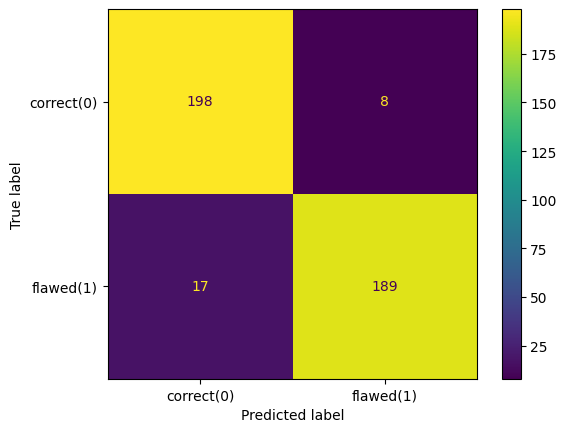

3 × 2 confusion matrix:
pred           correct  flawed
true                          
correct            198       8
conceptual          16      94
computational        1      95


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

PREDICTED_PROBAS_PATH = "/content/drive/MyDrive/Erdos/finetuning_data/test_probs/test_probs_qwen4B_finetuned.csv"

# ── 1 · load files ───────────────────────────────────────────────
probs_df  = pd.read_csv(PREDICTED_PROBAS_PATH)                 # your earlier export
meta_df   = pd.read_csv("/content/drive/MyDrive/Erdos/finetuning_data/level-1-binary/level-1-binary/sft_level1_catalog.csv")  # the metadata file

# ── 2 · merge on (index, true_label) ─────────────────────────────

# Rename label to true_label for consistency
meta_df.rename(columns={"label": "true_label"}, inplace=True)
df = probs_df.merge(meta_df, on=["index", "true_label"], how="inner")

# sanity-check
assert len(df) == len(probs_df), "some rows failed to merge"

# ── 3 · binary confusion matrix (correct = 0, incorrect = 1) ─────
# 3.1 predicted class from probs
prob_cols = [c for c in df.columns if c.startswith("p(class=")]
df["y_pred"]  = df[prob_cols].values.argmax(axis=1)            # 0 or 1
df["y_true"]  = df["true_label"]                               # 0 or 1

cm_bin = confusion_matrix(df["y_true"], df["y_pred"], labels=[0, 1])
print("Binary confusion-matrix (0=correct, 1=flawed):\n", cm_bin)

# (optional) visual
ConfusionMatrixDisplay(cm_bin, display_labels=["correct(0)", "flawed(1)"]).plot()
plt.show()

# ── 4 · 3-class confusion matrix ────────────────────────────────
# ── map ground-truth into three groups ───────────────────────────────────────
def collapse_error_type(row):
    if row["true_label"] == 0:
        return "correct"
    return "conceptual" if row["error_type"] == "conceptual" else "computational"

df["y_true_3"] = df.apply(collapse_error_type, axis=1)

# ── binary model output: 0 → correct, 1 → **generic “incorrect”** ────────────
df["y_pred_2"] = df["y_pred"].map({0: "correct", 1: "flawed"})

# ── 3 × 2 confusion matrix via crosstab ───────────────────────────
cm_3x2 = pd.crosstab(
    df["y_true_3"],
    df["y_pred_2"],
    rownames=["true"],
    colnames=["pred"],
    dropna=False,
).reindex(index=["correct", "conceptual", "computational"],
          columns=["correct", "flawed"],
          fill_value=0)

print("3 × 2 confusion matrix:")
print(cm_3x2)